In [1]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from finance.utilities import utils

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

#### Analytics on model predictions

In [2]:
MODEL_ID = 's1'
SYMBOL = 'ASML'
query = f'''
    with
    stocks as (
      select
          market_datetime
        , symbol
        , open
        , min(open) over (
          partition by symbol
          order by market_datetime
          rows between 1 following and 31 following
          ) as thirty_day_low
      from td.stocks
      where market_datetime between '2020-01-01' and '2020-10-10'
    )
    , predictions as (
      select *
        , denormalized_prediction as thirty_day_low_prediction
        , row_number() over (partition by symbol order by market_datetime desc) as rn
      from dev.predictions
      where model_id = '{MODEL_ID}'
    )
    select
        p.model_id
      , s.market_datetime
      , s.symbol
      , s.open
      , s.thirty_day_low
      , p.thirty_day_low_prediction
      , p.thirty_day_low_prediction >= s.thirty_day_low as is_loss
      , (p.thirty_day_low_prediction - s.thirty_day_low) / p.thirty_day_low_prediction as net_win_loss
      , greatest((p.thirty_day_low_prediction - s.thirty_day_low) / p.thirty_day_low_prediction, 0) as loss
      , min(case when s.open <= p.thirty_day_low_prediction then s.market_datetime end) over (partition by s.symbol order by s.market_datetime rows between 1 following and 31 following) - s.market_datetime as nearest_loss_date
    from stocks as s
    inner join predictions as p
      on  p.symbol = s.symbol
      and (p.market_datetime = s.market_datetime
        or p.market_datetime < s.market_datetime and p.rn = 1
      )
    order by 1,2,3
    --limit 10
    '''
df = utils.query_db(query=query)

In [3]:
df

,model_id,market_datetime,symbol,open,thirty_day_low,thirty_day_low_prediction,is_loss,net_win_loss,loss,nearest_loss_date
0,s1,2020-07-07,A,88.84,88.83,86.077255,False,-0.031980,0.000000,43.0
1,s1,2020-07-07,AA,11.23,10.49,8.224746,False,-0.275419,0.000000,NaN
2,s1,2020-07-07,AAMC,17.32,12.55,13.975626,True,0.102008,0.102008,NaN
3,s1,2020-07-07,AAN,44.33,42.25,37.668409,False,-0.121630,0.000000,NaN
4,s1,2020-07-07,AAP,137.92,133.31,130.863290,False,-0.018697,0.000000,NaN
...,...,...,...,...,...,...,...,...,...,...
5017,s1,2020-10-09,ALB,98.10,NaN,86.610401,None,NaN,0.000000,NaN
5018,s1,2020-10-09,ALE,54.85,NaN,47.699552,None,NaN,0.000000,NaN
5019,s1,2020-10-09,ALEX,12.32,NaN,9.900422,None,NaN,0.000000,NaN
5020,s1,2020-10-09,ALG,118.37,NaN,107.651959,None,NaN,0.000000,NaN


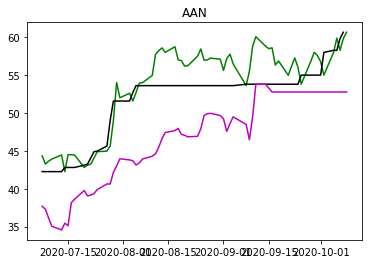

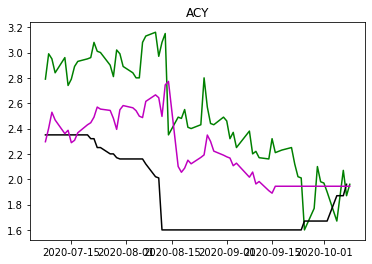

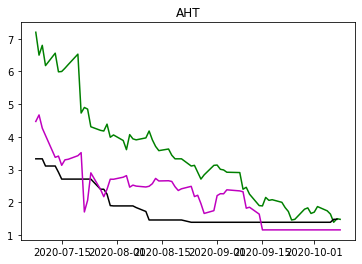

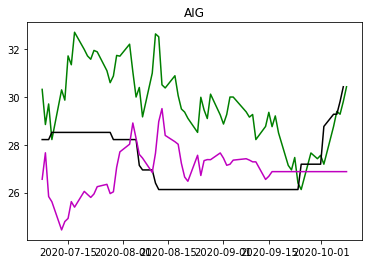

In [4]:
STOCKS = [
    'AAN',
    'ACY',
    'AHT',
    'AIG',
]

for s in STOCKS:
    x = df[df['symbol']==s]

    plt.title(s)
    plt.plot(x['market_datetime'], x['open'], color='g')
    plt.plot(x['market_datetime'], x['thirty_day_low'], color='black')
    plt.plot(x['market_datetime'], x['thirty_day_low_prediction'], color='m')
    plt.show()

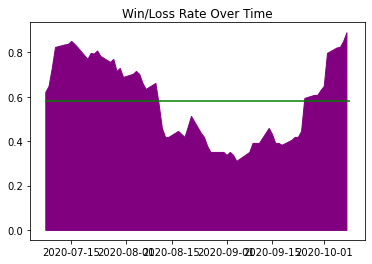

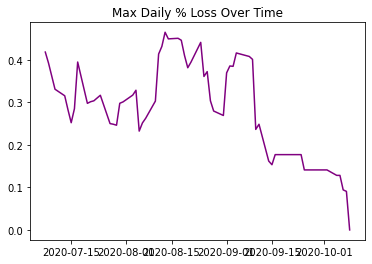

In [5]:
temp = df.groupby('market_datetime').agg(
    {
        'is_loss': ['sum', 'count'],
        'loss': 'max',
    }
)
x = 1 - (temp['is_loss']['sum'] / temp['is_loss']['count'])

plt.title('Win/Loss Rate Over Time')
plt.fill_between(x.index, x.values, color='purple')
plt.hlines(x.mean(), xmin=x.index.min(), xmax=x.index.max(), color='g')
plt.show()

plt.title('Max Daily % Loss Over Time')
plt.plot(temp['loss']['max'], color='purple')
plt.show()

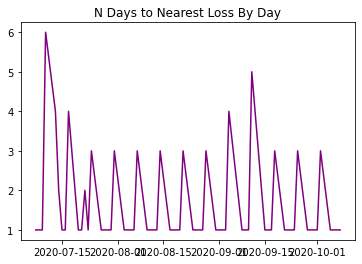

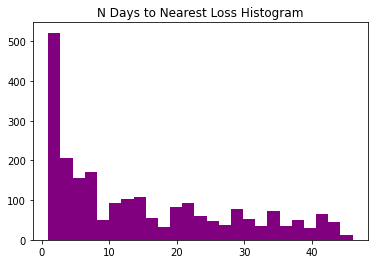

In [6]:
temp = df[df['nearest_loss_date'].notnull()].groupby('market_datetime').agg({'nearest_loss_date': min})

plt.title('N Days to Nearest Loss By Day')
plt.plot(temp['nearest_loss_date'], color='purple')
plt.show()

plt.title('N Days to Nearest Loss Histogram')
plt.hist(df.loc[df['nearest_loss_date'].notnull(), 'nearest_loss_date'], bins=25, color='purple')
plt.show()

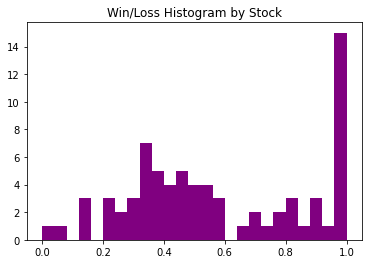

In [7]:
temp = df.groupby('symbol').agg({'is_loss': ['sum', 'count']})
x = 1 - (temp['is_loss']['sum'] / temp['is_loss']['count'])

plt.title('Win/Loss Histogram by Stock')
plt.hist(x, bins=25, color='purple')
plt.show()

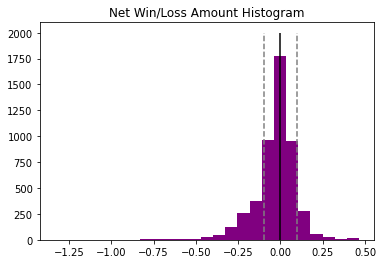

In [8]:
plt.title('Net Win/Loss Amount Histogram')
plt.hist(df.loc[df['net_win_loss'].notnull(), 'net_win_loss'], bins=25, color='purple')
plt.vlines(-.1, ymin=0, ymax=2000, color='grey', linestyles='dashed')
plt.vlines(0, ymin=0, ymax=2000, color='black')
plt.vlines(.1, ymin=0, ymax=2000, color='grey', linestyles='dashed')
plt.show()